# <font color=#cd0000> Propósito principal </font>
- La idea de este librillo es preparar el entorno para realizar pruebas para Heartbeat a ser clasificado con la codificación de la ``Tendencia`` junto con la ``Aceleración`` y LSTM

## <font color=#cd0000> Leyenda </font>
- Los apartados titulados con el código de colores HEX: `#d0000` serán apartados que tendrán todos los librillos, en concreto, aquellos especificados en el apartado `Síntesis de los criterios usados` del trabajo.
- Los apartados titulados con el código de colores HEX: `#2451ff` serán apartados de conclusiones propias de este librillo resultado de aplicar un estudio personalizado para cada planteamiento.

# <font color=#cd0000> Prerrequisitos </font>
## <font color=#cd0000> Entorno de ejecución </font>
- Cambiamos el directorio raíz del librillo para acceder cómodamente a las funciones de utilidad.

In [1]:
import os

os.chdir('../../../../')
os.listdir()


['.git',
 '.gitignore',
 '.gitmodules',
 'data',
 'HeartBeat_tmp_test_data.pkl',
 'HeartBeat_tmp_train_data.pkl',
 'pkl',
 'Pruebas',
 'README.md',
 'smts_implementation',
 'utils']

## <font color=#cd0000> Constantes y variables predefinidas </font>

In [2]:
HEARTBEAT_PATH = "data/heartbeat"

DATA_TO_SAVE = "HeartBeat"

PKL_DIR = "pkl/LSTM/Heartbeat/"
PKL_NAME = "heartbeat_LSTM_trend_acc.pkl"

SEED = 1


# <font color=#cd0000> Carga del Dataset </font>

In [3]:
# from utils.load_data import import_heartbeat_dataset

# train, test = import_heartbeat_dataset(HEARTBEAT_PATH)

In [4]:
# import pickle

# pickle.dump(train, open(DATA_TO_SAVE + "_tmp_train_data.pkl", 'wb'))
# pickle.dump(test, open(DATA_TO_SAVE + "_tmp_test_data.pkl", 'wb'))


In [5]:
import pickle

train = pickle.load(open(DATA_TO_SAVE + "_tmp_train_data.pkl", 'rb'))
test = pickle.load(open(DATA_TO_SAVE + "_tmp_test_data.pkl", 'rb'))


In [6]:
train.reset_changes()
test.reset_changes()


# <font color=#cd0000> Preprocesamiento </font>

## <font color=#cd0000> Eliminación de datos inválidos y valores atípicos </font>
- Como ya anticipamos en el análisis en profundidad de este conjunto de datos eliminaremos todos los atributos dado su alto grado de correlación salvo los atributos: `signal_1`, `signal_10`, `signal_20`, `signal_30`, `signal_40`, `signal_50` y `signal_60`
- Eliminaremos aquellos valores fuera de los percentiles 5 y 95.

### <font color=#2451ff> Eliminación de atributos altamente correlacionados </font>

In [7]:
columns_to_remove = train.get_derived_data_columns()['attrs']
column_to_study = ['signal_1', 'signal_10', 'signal_20',
                   'signal_30', 'signal_40', 'signal_50', 'signal_60']

for col in columns_to_remove:
    if col in column_to_study:
        columns_to_remove.remove(col)

train.drop_derived_data_columns(columns_to_remove)
test.drop_derived_data_columns(columns_to_remove)


,id,TimeStamp,signal_1,signal_10,signal_20,signal_30,signal_40,signal_50,signal_60,class
0,0,0,0.004578,0.009483,0.003414,0.009437,0.008221,0.030211,1.000400,normal
1,0,1,0.011682,0.013566,0.004089,0.012686,0.012927,0.070100,0.673670,normal
2,0,2,0.017709,0.019086,0.011413,0.030151,0.039722,0.100600,0.904520,normal
3,0,3,0.016318,0.017490,0.016408,0.044615,0.059496,0.091279,1.322500,normal
4,0,4,0.011723,0.008481,0.008594,0.025718,0.030744,0.024211,1.622600,normal
...,...,...,...,...,...,...,...,...,...,...
83020,204,400,0.007057,0.001993,0.005595,0.003932,0.002723,0.002055,0.353420,abnormal
83021,204,401,0.012607,0.002142,0.004760,0.000763,0.002429,0.001636,0.349890,abnormal
83022,204,402,0.011410,0.004370,0.000505,0.000902,0.002300,0.001022,0.264820,abnormal
83023,204,403,0.008735,0.003033,0.001830,0.001835,0.004181,0.002472,0.130270,abnormal


### <font color=#2451ff> Eliminación de outliers </font>
- El grado de outliers mínimo en, al menos, una dimensión para eliminar una serie temporal será del 80% (si más del 80% de los datos son anómalos descartamos la serie).
  - A pesar de que esto pueda parecer muy grande debemos comprender que, la probabilidad con la que aparezca ruido en una de las dimensiones de una serie temporal multivariada, es muy alta (tenemos varias series temporales con ruido cada una).

In [8]:
train.remove_outliers(
    headers=train.get_derived_data_columns()['attrs'],
    outliers_limit=.8
)

test.remove_outliers(
    headers=test.get_derived_data_columns()['attrs'],
    outliers_limit=.8
)


In [9]:
import pandas as pd

# Remaining series
print("Train: Previous number of series: {}".format(
    len(pd.unique(train.original_data['id']))))
print("Train: Actual number of series: {}".format(
    len(pd.unique(train.derived_data['id']))))

print("Test: Previous number of series: {}".format(
    len(pd.unique(test.original_data['id']))))
print("Test: Actual number of series: {}".format(
    len(pd.unique(test.derived_data['id']))))


Train: Previous number of series: 204
Train: Actual number of series: 198
Test: Previous number of series: 205
Test: Actual number of series: 199


## <font color=#cd0000> Resoluciones a aplicar </font>
- Como concluimos en el análisis en profundidad, mantendremos la resolución original.

In [10]:
# Nothing to see here


# <font color=#cd0000> División en ventanas </font>
- Como concluimos en el análisis en profundidad no aplicaremos enventanado pues ya está preaplicado.

In [11]:
# Nothing to see here


# <font color=#cd0000> Codificación </font>
- Tendencia

In [12]:
from utils.codifications import temporal_trend_fn

train.apply_codifications([temporal_trend_fn])
test.apply_codifications([temporal_trend_fn])

In [13]:
# Acceleration's codification (second derivative)
columns_to_derivate = list(filter(lambda z: 'Diff' in z,
                                  train.get_derived_data_columns()['attrs']))

train.apply_codifications([temporal_trend_fn], headers=columns_to_derivate)
test.apply_codifications([temporal_trend_fn], headers=columns_to_derivate)


## <font color=#cd0000> Normalización </font>

In [15]:
from utils.codifications import standardize_data

train.derived_data, test.derived_data = standardize_data(
    train.derived_data,
    test.derived_data,
    headers=train.get_derived_data_columns()['attrs']
)


## <font color=#cd0000> Tensores entrada y salida de la red </font>

In [16]:
# All lengths must be equal
series_length = train.get_shortest_serie().shape[0]
n_dims = len(train.get_derived_data_columns()['attrs'])

(
    train.get_shortest_serie().shape[0],
    train.get_largest_serie().shape[0],
    test.get_shortest_serie().shape[0],
    test.get_largest_serie().shape[0]
)


(403, 403, 403, 403)

In [17]:
import pandas as pd

# This will determine the number of series of each split
train_n_series = pd.unique(train.derived_data['id']).shape[0]
test_n_series = pd.unique(test.derived_data['id']).shape[0]

(train_n_series, test_n_series)


(198, 199)

In [18]:
X_train, _ = train.transform_derived_data_into_X_y()
X_test, _ = test.transform_derived_data_into_X_y()

y_train = train.derived_data.groupby('id').first()['class'].to_numpy()
y_test = test.derived_data.groupby('id').first()['class'].to_numpy()


## <font color=#cd0000> Técnicas de balanceo </font>

### <font color=#cd0000> Asignación de pesos a las clases </font>

In [19]:
import numpy as np
from sklearn.utils import compute_class_weight

class_weights = compute_class_weight(
    'balanced', classes=np.unique(y_train), y=y_train)
class_weights = {0: class_weights[0], 1: class_weights[1]}


In [20]:
from utils.classifier_utils import apply_lstm_format
from sklearn.preprocessing import LabelEncoder

sequences_fragmenter = 1

enc = LabelEncoder()
enc.fit(y_train)

X_train, y_train = apply_lstm_format(
    X_train, y_train, train_n_series, series_length, sequences_fragmenter, enc)
X_test, y_test = apply_lstm_format(
    X_test, y_test, test_n_series, series_length, sequences_fragmenter, enc)


# <font color=#cd0000> Diseño de la topología de red </font>

In [21]:
len(train.get_derived_data_columns()['attrs'])

21

In [27]:
import keras as k
from keras.models import Sequential
from keras.layers import LSTM, Dense

nn = Sequential()

# Number of initial dimensions
nn.add(LSTM(units=56, return_sequences=True, dropout=.2, recurrent_dropout=.2))
nn.add(LSTM(units=28, dropout=.2, recurrent_dropout=.2))
# Number of Heartbeat's classes
nn.add(Dense(1, activation='sigmoid'))

## <font color=#cd0000> Compilación de la red </font>

In [28]:
from keras.optimizers import RMSprop

metrics = [
    k.metrics.CategoricalAccuracy(name="ACC"),
    k.metrics.Precision(name='Prec'),
    k.metrics.Recall(name='Rec'),
    k.metrics.AUC(name='AUC')
]

nn.compile(optimizer=RMSprop(
    learning_rate=1e-4), loss='binary_crossentropy', metrics=metrics)


## <font color=#cd0000> Visualización de resultados preliminares </font>

In [29]:
import matplotlib.pyplot as plt


def show_metrics(history):
    for metric in history.history.keys():
        if not metric.startswith('val_'):
            plt.plot(history.history[metric], label=metric)
            plt.plot(history.history[f'val_{metric}'], label=f'val_{metric}')
            plt.title(metric)
            plt.ylabel('')
            plt.xlabel('Epoch')
            plt.legend(loc="upper left")
            plt.show()


## <font color=#cd0000> Entrenamiento del modelo </font>

Epoch 1/75
7/7 [==============================] - 4s 511ms/step - loss: 0.6971 - ACC: 1.0000 - Prec: 0.2083 - Rec: 0.2632 - AUC: 0.4291 - val_loss: 0.6897 - val_ACC: 1.0000 - val_Prec: 0.2923 - val_Rec: 0.3393 - val_AUC: 0.5381
Epoch 2/75
7/7 [==============================] - 3s 412ms/step - loss: 0.6915 - ACC: 1.0000 - Prec: 0.3472 - Rec: 0.4386 - AUC: 0.5861 - val_loss: 0.6878 - val_ACC: 1.0000 - val_Prec: 0.3281 - val_Rec: 0.3750 - val_AUC: 0.5672
Epoch 3/75
7/7 [==============================] - 3s 399ms/step - loss: 0.6889 - ACC: 1.0000 - Prec: 0.3538 - Rec: 0.4035 - AUC: 0.5929 - val_loss: 0.6875 - val_ACC: 1.0000 - val_Prec: 0.3286 - val_Rec: 0.4107 - val_AUC: 0.5702
Epoch 4/75
7/7 [==============================] - 4s 581ms/step - loss: 0.6880 - ACC: 1.0000 - Prec: 0.3500 - Rec: 0.3684 - AUC: 0.6074 - val_loss: 0.6859 - val_ACC: 1.0000 - val_Prec: 0.3636 - val_Rec: 0.4286 - val_AUC: 0.5829
Epoch 5/75
7/7 [==============================] - 5s 663ms/step - loss: 0.6840 - ACC: 1.

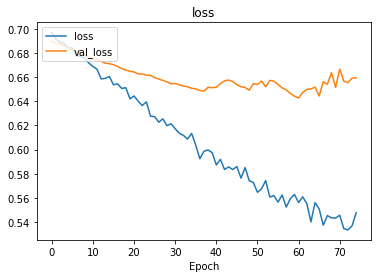

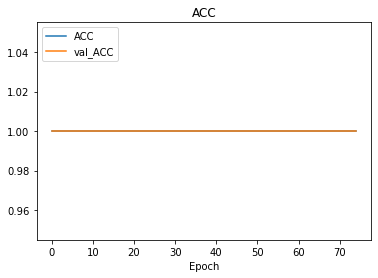

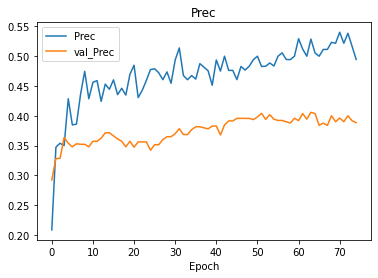

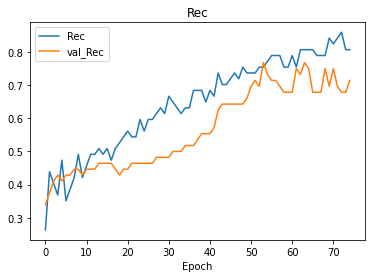

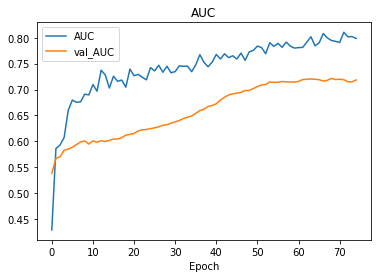

In [30]:
import numpy as np
from keras import backend as K
from sklearn.metrics import confusion_matrix, classification_report

epochs = 75

history = nn.fit(X_train, y_train, epochs=epochs,
                 validation_data=(X_test, y_test),
                 class_weight=class_weights,
                 verbose=1)
nn.summary()
print('\n\n')

y_pred = nn.predict(X_test)
y_pred = y_pred > .5

show_metrics(history)

## <font color=#cd0000> Clasificación </font>

In [31]:
y_real = enc.inverse_transform(y_test)
y_pred = y_pred.astype('int')
y_pred = enc.inverse_transform(y_pred)
print(confusion_matrix(y_real, y_pred))
print(classification_report(y_real, y_pred, zero_division=0))


[[80 63]
 [16 40]]
              precision    recall  f1-score   support

    abnormal       0.83      0.56      0.67       143
      normal       0.39      0.71      0.50        56

    accuracy                           0.60       199
   macro avg       0.61      0.64      0.59       199
weighted avg       0.71      0.60      0.62       199



c:\Users\Javier\anaconda3\envs\tfg_env\lib\site-packages\sklearn\preprocessing\_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## <font color=#cd0000> Discusión de los resultados </font>
- Dimensionalidad de entrada inicial -> 14 atributos
- Vamos a estudiar diferentes rangos de hiper-parámetros que podrían darnos alguna pista sobre el rango en el que buscar el mejor clasificador de este tipo:
  - Dado que las series son algo complejas convendría añadir algo de profundidad al modelo para adaptarlo a dicha complejidad, pero con el fin de probar diferentes arquitecturas empezaremos con una capa oculta que iremos aumentando de complejidad en función de su nº de neuronas:
    - Para un `n_units` de la dim_entrada (14) y un `learning_rate` rápido (1e-2) obtenemos los resultados que ya obteníamos en el resto de clasificadores, probaremos a partir del mejor punto en que nos quedamos que eran 2 capas ocultas con Dropout a 0.2, un nº reducido de épocas y para `n_units_capa1` 56 neuronas y para `n_units_capa2` 28 neuronas:
   ```
   Confusion matrix:
   [[98 45]
    [32 24]]

   Classification report:
                  precision    recall  f1-score   support

      abnormal       0.75      0.69      0.72       143
        normal       0.35      0.43      0.38        56

      accuracy                           0.61       199
     macro avg       0.55      0.56      0.55       199
  weighted avg       0.64      0.61      0.62       199
   ```
  - Probamos con 2 capas ocultas con Dropout a 0.2 en ambas:
    - Para un `n_units_capa1` de 56, un `n_units_capa2` de 28, un `learning_rate` lento (1e-4) y un número de época s de 75, obtenemos una ligera mejora:
   ```
   Confusion matrix:
   [[80 63]
    [16 40]]

   Classification report:
                  precision    recall  f1-score   support

      abnormal       0.83      0.56      0.67       143
        normal       0.39      0.71      0.50        56

      accuracy                           0.60       199
     macro avg       0.61      0.64      0.59       199
  weighted avg       0.71      0.60      0.62       199
   ```

## <font color=#cd0000> Conclusiones </font>
- Como podemos observar los resultados son algo mejores ya que la red mantiene información a un mayor plazo en sus memorias algo que no contemplaba un RandomForest
- Los rangos orientativos de búsqueda podrían ser:
  - `n_units_capa1`: [28, 56]
  - `n_units_capa2` fijo a 28
  - `learning_rate`: [1e-3, 8e-4, 7e-4, 5e-4, 1e-4]

# <font color=#cd0000> Randomized Search </font>
- Búsqueda de hiper-parámetros aleatoria con LSTM maximizando ``macro avg f1-score``

## <font color=#cd0000> Rangos de búsqueda </font>
- Como vimos anteriormente los rangos de búsqueda aleatoria de los mejores hiper-parámetros serán los siguientes

In [32]:
N_UNITS_RANGE = range(28, 56)
LEARNING_RATE_CHOICES = [1e-3, 8e-4, 7e-4, 5e-4, 3e-4]

In [33]:
import random
import pickle
import utils.constants as cs
from utils.classifier_utils import (windowed_cross_val,
                                    compute_classification_reports_means)
from utils.plot_utils import pretty_print_classification_report_dict
from keras.layers import LSTM, Dense
from keras.optimizers import RMSprop


def lstm_randomized_search_cv(
        windowed_series,
        relation_with_series,
        prefix,
        cv=5,
        lstm_dict={}):
    global PKL_DIR
    all_clf_used = {}

    n_samples = 5
    units_list = random.sample(
        list(N_UNITS_RANGE), n_samples)
    learning_rate_list = random.sample(
        LEARNING_RATE_CHOICES, n_samples)

    best_hyp_params = None
    best_score = 0
    for units in units_list:
        for learning_rate in learning_rate_list:
            lstm_dict[cs.LSTM_HYP_PARAM_UNITS] = units
            lstm_dict[cs.LSTM_HYP_PARAM_LEARNING_RATE] = learning_rate
            reports = windowed_cross_val(
                None,
                windowed_series,
                relation_with_series,
                cv=cv,
                seed=SEED,
                drop_columns=['class'],
                estimator_type=cs.ESTIMATOR_LSTM,
                lstm_dict=lstm_dict
            )

            mean_report = compute_classification_reports_means(reports)
            all_clf_used[(units, learning_rate)] = mean_report

            if mean_report['macro avg']['f1-score'][0] >= best_score:
                best_score = mean_report['macro avg']['f1-score'][0]
                best_hyp_params = (units, learning_rate)
                best_report = mean_report

            print("\t\t--------------ACTUAL BEST: Units={}; Learning Rate={}--------------"
                  .format(best_hyp_params[0], best_hyp_params[1]))
            pretty_print_classification_report_dict(best_report)
            print("\t\t--------------ITERATION: Units={}; Learning Rate={}--------------"
                  .format(units, learning_rate))
            pretty_print_classification_report_dict(mean_report)

    with open(PKL_DIR + prefix, 'wb') as file:
        pickle.dump(all_clf_used, file)

    return best_hyp_params, best_report


In [34]:
# IMPORTANTE -> ALGUNOS DE LOS PARÁMETROS DEL MODELO SON FIJADOS EN EL MÉTODO lstm_build_model del módulo
# classifier_utils.py ante problemas a la hora de clonar modelos neuronales de Keras.

# Los parámetros fijados a fuego en el código son:
#   · Una segunda capa oculta con el nº de neuronas fijas a 28
#   · Las tasas de Dropout recurrentes y de la misma capa a 0.2

lstm_dict = {
    cs.LSTM_SERIES_LENGTH: series_length,
    cs.LSTM_SEQUENCES_FRAGMENTER: 1,
    cs.LSTM_FITTED_LABELS_ENCODER: enc,
    cs.LSTM_ARGMAX_FUNCTION: None,
    cs.LSTM_N_CLASSES: 2,
    cs.LSTM_CLASS_WEIGHTS: class_weights,
    cs.LSTM_HYP_PARAM_EPOCHS: 75
}

lstm_randomized_search_cv(
    train.derived_data,
    train.derived_data_windows_per_serie,
    PKL_NAME,
    cv=5,
    lstm_dict=lstm_dict
)


		--------------ACTUAL BEST: Units=34; Learning Rate=0.0007--------------
Accuracy: 0.9799937460913071 +/- 0.010010946171553844
abnormal:
	precision: 0.9872983870967742 +/- 0.015559501114173167
	recall: 0.9859605911330049 +/- 0.01719910369467594
	f1-score: 0.9864015727346184 +/- 0.006848021572139637
	support: 28.2 +/- 2.7856776554368237
normal:
	precision: 0.9690476190476189 +/- 0.0380952380952381
	recall: 0.9550000000000001 +/- 0.055677643628300216
	f1-score: 0.9600372912958726 +/- 0.022322806242977652
	support: 11.4 +/- 2.4166091947189146
macro avg:
	precision: 0.9781730030721965 +/- 0.015058676218995756
	recall: 0.9704802955665024 +/- 0.023088213280106063
	f1-score: 0.9732194320152455 +/- 0.01415291052944878
	support: 39.6 +/- 1.0198039027185568
weighted avg:
	precision: 0.98108039154656 +/- 0.00949412479318146
	recall: 0.9799937460913071 +/- 0.010010946171553844
	f1-score: 0.9798837349619782 +/- 0.010083956424468084
	support: 39.6 +/- 1.0198039027185568
		--------------ITERATION: U

((51, 0.001),
 {'accuracy': (0.9801156973108192, 0.01835794497884113),
  'abnormal': {'precision': (0.9804166666666667, 0.02647063362378098),
   'recall': (0.993103448275862, 0.013793103448275846),
   'f1-score': (0.9864200731714343, 0.012858679738137124),
   'support': (28.2, 2.7856776554368237)},
  'normal': {'precision': (0.9833333333333332, 0.03333333333333335),
   'recall': (0.9442307692307692, 0.06890951102757276),
   'f1-score': (0.961304347826087, 0.03403668776866677),
   'support': (11.4, 2.4166091947189146)},
  'macro avg': {'precision': (0.9818749999999999, 0.0170222485131796),
   'recall': (0.9686671087533156, 0.032285986292675185),
   'f1-score': (0.9738622104987608, 0.023187765210823687),
   'support': (39.6, 1.0198039027185568)},
  'weighted avg': {'precision': (0.9813430268918074, 0.017173313515531797),
   'recall': (0.9801156973108192, 0.01835794497884113),
   'f1-score': (0.979811997697227, 0.018759516945138256),
   'support': (39.6, 1.0198039027185568)}})

# <font color=#cd0000> Randomized Search con múltiples ejecuciones en lugar de Validación Cruzada </font>
- En este caso ejecutaremos CV dado que tenemos suficientes series

In [ ]:
# Nothing to see here

# <font color=#cd0000> Análisis de resultados </font>
- Según la búsqueda aleatoria de hiper-parámetros, la mejor combinación, es la de ``n_units`` = 51 y ``learning_rate`` = 0.001:
    ```
        Accuracy: 0.9801156973108192 +/- 0.01835794497884113
        abnormal:
            precision: 0.9804166666666667 +/- 0.02647063362378098
            recall: 0.993103448275862 +/- 0.013793103448275846
            f1-score: 0.9864200731714343 +/- 0.012858679738137124
            support: 28.2 +/- 2.7856776554368237
        normal:
            precision: 0.9833333333333332 +/- 0.03333333333333335
            recall: 0.9442307692307692 +/- 0.06890951102757276
            f1-score: 0.961304347826087 +/- 0.03403668776866677
            support: 11.4 +/- 2.4166091947189146
        macro avg:
            precision: 0.9818749999999999 +/- 0.0170222485131796
            recall: 0.9686671087533156 +/- 0.032285986292675185
            f1-score: 0.9738622104987608 +/- 0.023187765210823687
            support: 39.6 +/- 1.0198039027185568
        weighted avg:
            precision: 0.9813430268918074 +/- 0.017173313515531797
            recall: 0.9801156973108192 +/- 0.01835794497884113
            f1-score: 0.979811997697227 +/- 0.018759516945138256
            support: 39.6 +/- 1.0198039027185568
    ```
- Ahora vamos a visualizar la evolución de los resultados (25 resultados) para observar cómo avanza nuestra métrica objetivo -> Macro Average F1-Score.

In [35]:
import pickle

all_reports = pickle.load(open(PKL_DIR + PKL_NAME, 'rb'))


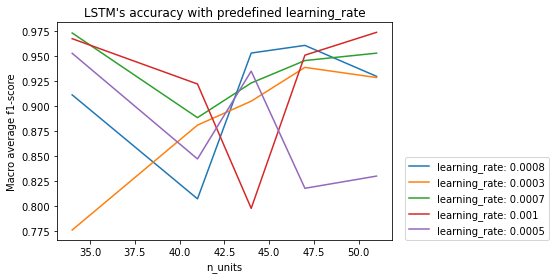

In [36]:
from utils.plot_utils import plot_score

macro_avg_f1_scores = dict(map(
    lambda z: (z, {'score': all_reports[z]['macro avg']['f1-score'][0],
                   'std': all_reports[z]['macro avg']['f1-score'][1]}),
    all_reports
))

plot_score(
    [macro_avg_f1_scores],
    ('n_units', 'learning_rate'),
    'LSTM',
    inverse=False,
    mode='score',
    in_same_graphic=True,
    accuracy_mode='accuracy',
    metric_name='Macro Average F1-Score'
)


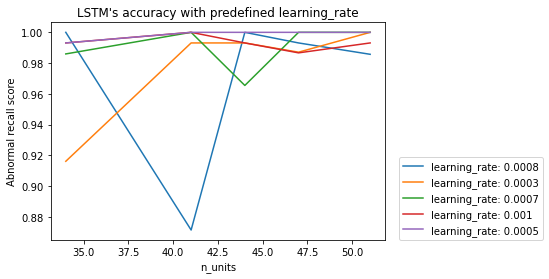

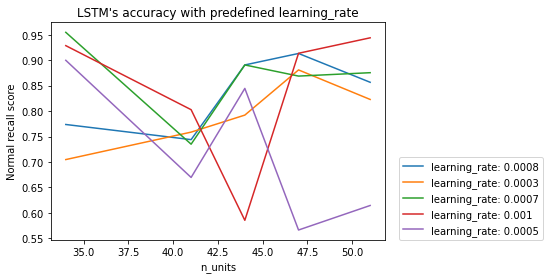

In [37]:
abnormal_recall_scores = dict(map(
    lambda z: (z, {'score': all_reports[z]['abnormal']['recall'][0],
                   'std': all_reports[z]['abnormal']['recall'][1]}),
    all_reports
))

normal_recall_scores = dict(map(
    lambda z: (z, {'score': all_reports[z]['normal']['recall'][0],
                   'std': all_reports[z]['normal']['recall'][1]}),
    all_reports
))

plot_score(
    [abnormal_recall_scores],
    ('n_units', 'learning_rate'),
    'LSTM',
    inverse=False,
    mode='score',
    in_same_graphic=True,
    accuracy_mode='accuracy',
    metric_name='Abnormal recall score'
)

plot_score(
    [normal_recall_scores],
    ('n_units', 'learning_rate'),
    'LSTM',
    inverse=False,
    mode='score',
    in_same_graphic=True,
    accuracy_mode='accuracy',
    metric_name='Normal recall score'
)


## <font color=#cd0000> Evaluación sobre el conjunto de validación </font>
- Vamos a llevar a cabo la evaluación final sobre el conjunto de validación (esto es lo que irá al apartado de ``Pruebas y Resultados`` de la memoria).

### <font color=#cd0000> Construcción del modelo </font>

In [38]:
import keras as k
from keras.models import Sequential
from keras.layers import LSTM, Dense

nn = Sequential()

# Number of initial dimensions
nn.add(LSTM(units=51, return_sequences=True, dropout=.2, recurrent_dropout=.2))
nn.add(LSTM(units=28, dropout=.2, recurrent_dropout=.2))
# Number of Heartbeat's classes
nn.add(Dense(1, activation='sigmoid'))

In [39]:
from keras.optimizers import RMSprop

metrics = [
    k.metrics.CategoricalAccuracy(name="ACC"),
    k.metrics.Precision(name='Prec'),
    k.metrics.Recall(name='Rec'),
    k.metrics.AUC(name='AUC')
]

nn.compile(optimizer=RMSprop(
    learning_rate=0.001), loss='binary_crossentropy', metrics=metrics)


### <font color=#cd0000> Entrenamiento </font>

Epoch 1/75
7/7 [==============================] - 4s 573ms/step - loss: 0.6332 - ACC: 1.0000 - Prec: 0.4091 - Rec: 0.3158 - AUC: 0.5855 - val_loss: 0.6057 - val_ACC: 1.0000 - val_Prec: 0.3514 - val_Rec: 0.2321 - val_AUC: 0.5973
Epoch 2/75
7/7 [==============================] - 3s 358ms/step - loss: 0.5594 - ACC: 1.0000 - Prec: 0.5806 - Rec: 0.3158 - AUC: 0.6779 - val_loss: 0.5803 - val_ACC: 1.0000 - val_Prec: 0.4167 - val_Rec: 0.1786 - val_AUC: 0.6289
Epoch 3/75
7/7 [==============================] - 3s 362ms/step - loss: 0.5307 - ACC: 1.0000 - Prec: 0.5926 - Rec: 0.2807 - AUC: 0.7330 - val_loss: 0.5896 - val_ACC: 1.0000 - val_Prec: 0.4444 - val_Rec: 0.2143 - val_AUC: 0.6568
Epoch 4/75
7/7 [==============================] - 2s 346ms/step - loss: 0.5303 - ACC: 1.0000 - Prec: 0.5926 - Rec: 0.2807 - AUC: 0.7286 - val_loss: 0.5806 - val_ACC: 1.0000 - val_Prec: 0.4483 - val_Rec: 0.2321 - val_AUC: 0.6673
Epoch 5/75
7/7 [==============================] - 3s 359ms/step - loss: 0.5075 - ACC: 1.

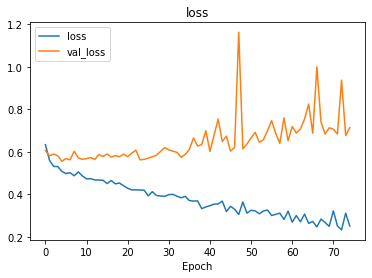

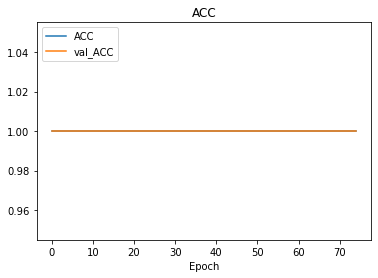

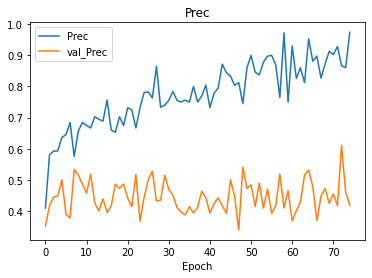

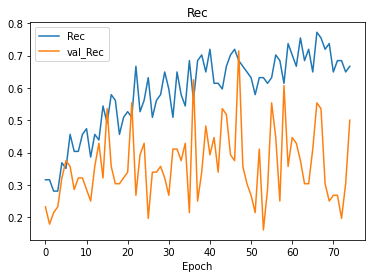

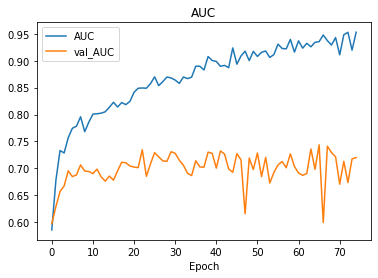

In [40]:
import numpy as np
from keras import backend as K
from sklearn.metrics import confusion_matrix, classification_report

epochs = 75

history = nn.fit(X_train, y_train, epochs=epochs,
                 validation_data=(X_test, y_test))
nn.summary()
print('\n\n')

y_pred = nn.predict(X_test)
y_pred = y_pred > .5

show_metrics(history)

### <font color=#cd0000> Clasificación </font>

In [41]:
y_real = enc.inverse_transform(y_test)
y_pred = y_pred.astype('int')
y_pred = enc.inverse_transform(y_pred)
print(confusion_matrix(y_real, y_pred))
print(classification_report(y_real, y_pred, zero_division=0))

[[104  39]
 [ 28  28]]
              precision    recall  f1-score   support

    abnormal       0.79      0.73      0.76       143
      normal       0.42      0.50      0.46        56

    accuracy                           0.66       199
   macro avg       0.60      0.61      0.61       199
weighted avg       0.68      0.66      0.67       199



c:\Users\Javier\anaconda3\envs\tfg_env\lib\site-packages\sklearn\preprocessing\_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# <font color=#cd0000> Conclusiones </font>
- Por lo que podemos observar obtenemos resultados ligeramente mejores a los de clasificar las series en bruto aunque también ligeramente peores que si clasificásemos solo con la codificación de la tendencia.